In [51]:
%matplotlib inline
from astropy.table import Table
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, precision_recall_curve, roc_auc_score, roc_curve, silhouette_samples
from plot_confusion import plot_confusion
import query

plt.rcParams["figure.figsize"] = (12, 8)

## Retrieving training data

In [3]:
data_train = query.query('training')

Retrieving training dataset
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
classification
star      15000
galaxy    15000
quasar    15000
Name: count, dtype: int64


In [5]:
features = ['sinb', 'parallax', 'pm', 'uwe', 'phot_g_mean_mag', 'bp_g', 'g_rp', 'relvarg']
X_train = data_train[features]
y_train = data_train['classification']

In [7]:
print(X_train.shape)
X_train

(45000, 8)


,sinb,parallax,pm,uwe,phot_g_mean_mag,bp_g,g_rp,relvarg
0,-0.057674,1.084924,4.807036,1.047432,15.244129,0.697942,0.824186,3.374237
1,-0.115781,0.854356,5.126574,0.916613,20.906347,0.171606,0.530489,0.420828
2,-0.267079,1.042008,3.773118,1.075526,20.531225,0.540527,1.108757,0.629736
3,0.072220,0.587660,5.458426,1.112896,20.145899,1.036097,0.970676,0.711846
4,-0.082779,-0.293376,3.440261,1.296980,19.787357,0.317444,1.255966,0.658233
...,...,...,...,...,...,...,...,...
44995,-0.737606,-0.111283,0.227769,1.010828,19.950802,0.253872,0.484562,0.495884
44996,0.503889,0.046263,0.037034,0.998661,17.467607,0.162373,0.319386,1.187506
44997,0.751927,0.367552,0.272514,1.054746,20.266418,0.105604,0.310760,0.638267
44998,0.832245,0.275054,0.569204,1.075054,19.904621,0.377867,0.666857,0.723502


## Retrieving testing data

In [11]:
data_test = query.query('testing')

Retrieving testing dataset
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
classification
star      150000
galaxy    150000
quasar    150000
Name: count, dtype: int64


In [13]:
X_test = data_test[features]
y_test = data_test['classification']

In [17]:
print(X_test.shape)
X_test

(450000, 8)


,sinb,parallax,pm,uwe,phot_g_mean_mag,bp_g,g_rp,relvarg
0,-0.194087,3.584213,4.623216,1.448920,20.719471,0.022005,1.391302,0.435628
1,-0.581519,1.142770,7.643542,1.017828,19.482538,0.939579,0.968445,0.897924
2,0.165368,0.346427,5.217850,0.998876,19.321310,1.025518,1.012436,1.114729
3,-0.031604,0.350206,7.168854,1.100161,15.182426,0.897135,0.941528,4.208434
4,0.028213,1.233711,2.206847,1.179737,19.897621,1.716175,1.329288,0.682045
...,...,...,...,...,...,...,...,...
449995,0.906362,-0.484358,0.419653,1.063542,20.016417,0.198954,0.467585,0.648661
449996,0.982488,0.137493,0.114469,0.994921,18.139908,0.279821,0.538733,1.159123
449997,0.538144,-0.456997,0.416406,1.069046,19.506428,-0.024504,0.650620,0.679382
449998,0.659341,-0.131018,0.499734,0.987522,19.311808,0.238594,0.426994,0.760460


## Hyperparameter Tuning

In [29]:
params = {'n_estimators': list(range(100, 1000)),
'max_depth': list(range(1, 14)),
'min_samples_split': [2, 3, 4]}

search = RandomizedSearchCV(RandomForestClassifier(random_state=42), params, cv=5, n_iter = 50, n_jobs=-1)


In [31]:
search.fit(X_train, y_train)
print(accuracy_score(y_train, search.predict(X_train)))

0.9999111111111111


In [37]:
print("Best hyperparameters:", search.best_estimator_)
print("Best min_samples_split:", search.best_params_['min_samples_split'])
print("Best scores:", search.best_score_)

# Test set evaluation
best_model = search.best_estimator_

Best hyperparameters: RandomForestClassifier(max_depth=13, n_estimators=353, random_state=42)
Best min_samples_split: 2
Best scores: 0.9987111111111112


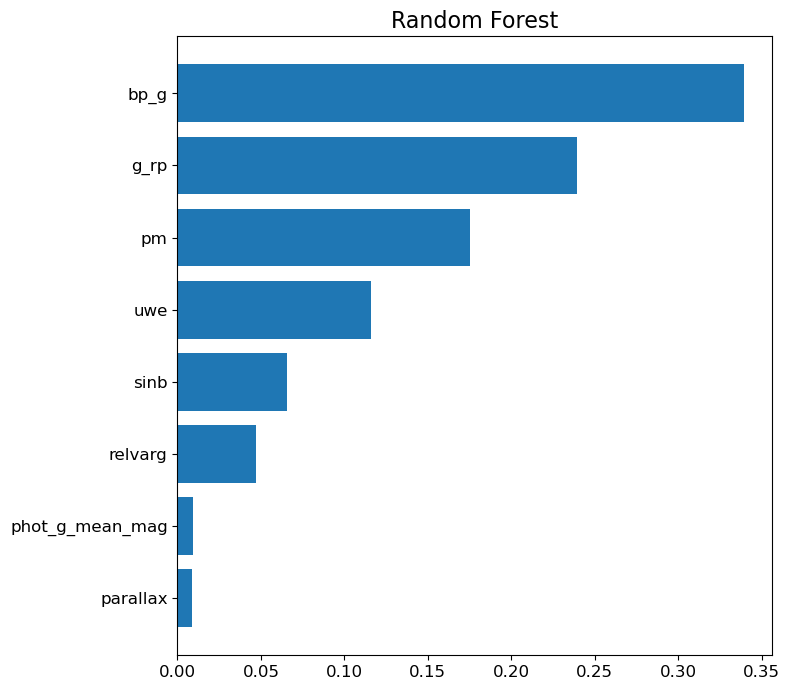

In [39]:
gini_importance = best_model.feature_importances_

# Sorting by Gini importance
sorted_idx = np.argsort(gini_importance)[::-1]  # descending order

# Sorting to features and importances
sorted_features = np.array(features)[sorted_idx]
sorted_importances = gini_importance[sorted_idx]

plt.figure(figsize=(8, 7))
plt.barh(sorted_features, sorted_importances)
plt.title("Random Forest", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('Featureimp_RF')
plt.show()

# Testing

In [41]:
best_model.fit(X_train,y_train)

RandomForestClassifier(max_depth=13, n_estimators=353, random_state=42)

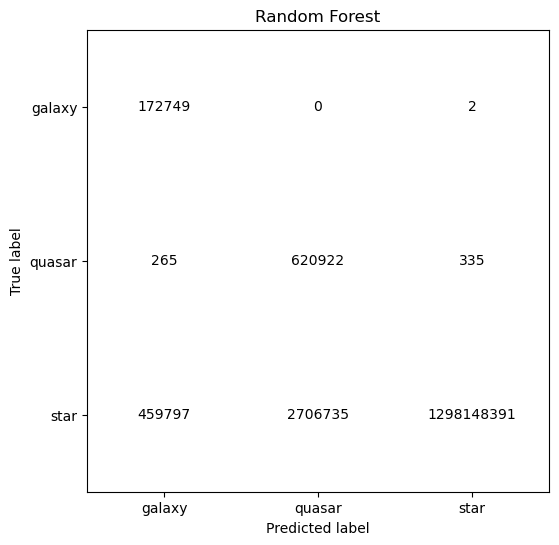

In [47]:
y_pred = best_model.predict(X_test)

labels = best_model.classes_

plot_confusion(y_test, y_pred, labels = labels, title = 'Random Forest', savefig = True, corrected  = True)

In [55]:
confusion_matrix(y_test, y_pred)

array([[149998,      0,      2],
       [    64, 149855,     81],
       [    53,    312, 149635]])

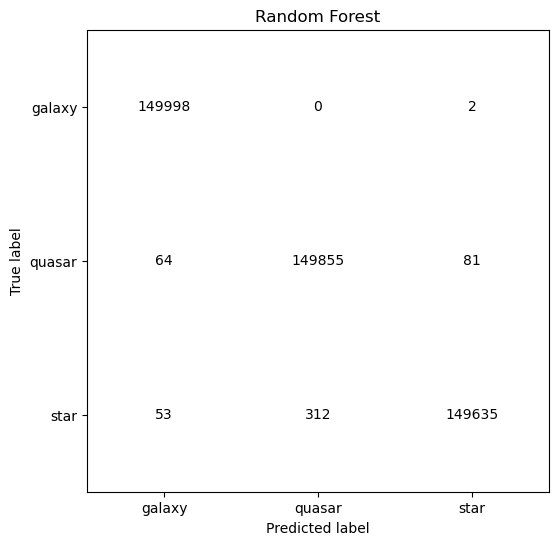

In [59]:
plot_confusion(y_test, y_pred, labels = labels, title = 'Random Forest', savefig = True, corrected  = False)

In [61]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      galaxy       1.00      1.00      1.00    150000
      quasar       1.00      1.00      1.00    150000
        star       1.00      1.00      1.00    150000

    accuracy                           1.00    450000
   macro avg       1.00      1.00      1.00    450000
weighted avg       1.00      1.00      1.00    450000

